!pip install pyarrow

!pip install fastparquet

In [3]:
# See python version
!python -V

Python 3.9.12


In [5]:
import pandas as pd

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
from sklearn.feature_extraction import DictVectorizer

In [8]:
from sklearn.linear_model import LinearRegression

In [9]:
#Import mean_squared_error
from sklearn.metrics import mean_squared_error

In [10]:
#Import lasso
from sklearn.linear_model import Lasso

In [11]:
import pickle

In [12]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [13]:
## Read the data 
df = pd.read_parquet('data/green_tripdata_2021-01.parquet')

In [14]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,0.50,0.5,0.00,0.00,NaN,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,0.50,0.5,2.81,0.00,NaN,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,0.50,0.5,1.00,0.00,NaN,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,0.50,0.5,0.00,0.00,NaN,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.00,0.00,-0.5,0.00,0.00,NaN,-0.3,-52.80,3.0,1.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,2.75,0.0,0.00,6.12,NaN,0.3,65.40,NaN,NaN,NaN
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,0.00,0.0,12.20,6.12,NaN,0.3,65.28,NaN,NaN,NaN
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,2.75,0.0,0.00,0.00,NaN,0.3,22.00,NaN,NaN,NaN
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,2.75,0.0,0.00,6.12,NaN,0.3,58.04,NaN,NaN,NaN


In [15]:
## Formattiing the datetime columns
df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)


In [16]:
## Create a new column with the duration of the trip
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime

In [17]:
#Transform the duration column to minutes
df.duration = df.duration.apply(lambda td: td.total_seconds()/60)

In [18]:
## Trip_tipe indicates whether the trip was a street-hail or a distpatch.
df = df[df['trip_type']==2]

In [19]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
6,2,2021-01-01 00:19:14,2021-01-01 00:19:21,N,5.0,265,265,1.0,0.00,180.0,...,0.0,36.06,0.0,NaN,0.3,216.36,1.0,2.0,0.0,0.116667
15,2,2021-01-01 00:29:05,2021-01-01 00:29:07,N,5.0,42,264,1.0,0.00,10.0,...,0.0,2.06,0.0,NaN,0.3,12.36,1.0,2.0,0.0,0.033333
30,2,2021-01-01 00:35:29,2021-01-01 00:55:15,N,5.0,74,247,1.0,3.64,13.0,...,0.0,0.00,0.0,NaN,0.3,13.30,2.0,2.0,0.0,19.766667
43,2,2021-01-01 23:12:41,2021-01-02 01:13:53,N,5.0,95,82,1.0,0.00,9.7,...,0.0,2.00,0.0,NaN,0.3,12.00,1.0,2.0,0.0,121.200000
45,2,2021-01-01 01:49:29,2021-01-01 01:49:33,N,5.0,244,244,5.0,0.02,12.0,...,0.0,2.46,0.0,NaN,0.3,14.76,1.0,2.0,0.0,0.066667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40363,2,2021-01-31 19:26:20,2021-01-31 19:35:47,N,5.0,167,248,2.0,1.31,10.0,...,0.0,0.00,0.0,NaN,0.3,10.30,2.0,2.0,0.0,9.450000
40364,2,2021-01-31 19:44:54,2021-01-31 20:19:56,N,5.0,147,147,2.0,6.97,30.0,...,0.0,0.00,0.0,NaN,0.3,30.30,2.0,2.0,0.0,35.033333
40377,2,2021-01-31 20:09:41,2021-01-31 20:10:21,N,5.0,95,95,1.0,0.00,15.0,...,0.0,3.06,0.0,NaN,0.3,18.36,1.0,2.0,0.0,0.666667
40394,2,2021-01-31 20:38:42,2021-01-31 20:38:45,N,5.0,75,264,1.0,0.00,5.0,...,0.0,0.20,0.0,NaN,0.3,5.50,1.0,2.0,0.0,0.050000


c:\Users\User\anaconda3\envs\mlflow_enviroment\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='duration', ylabel='Density'>

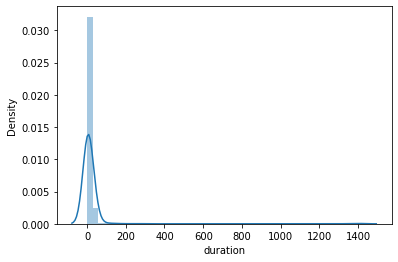

In [20]:
#Visualize distribution of duration
sns.distplot(df.duration)

In [21]:
# Better use describe
df.duration.describe()

count    1238.000000
mean       18.305493
std       108.364382
min         0.000000
25%         0.100000
50%         1.666667
75%        14.216667
max      1416.100000
Name: duration, dtype: float64

In [22]:
## With 95,98 and 99 percentiles
df.duration.describe(percentiles= [0.05,0.95,0.98,0.99])

count    1238.000000
mean       18.305493
std       108.364382
min         0.000000
5%          0.033333
50%         1.666667
95%        35.604167
98%        59.339333
99%       149.837833
max      1416.100000
Name: duration, dtype: float64

In [23]:
df = df[(df.duration >=1)& (df.duration <=60)]

In [24]:
#Categorical that'll be use 
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [25]:
df[categorical].dtypes

PULocationID    int64
DOLocationID    int64
dtype: object

In [26]:
#One Hot Encoding to categorical columns
# First change PUL and DOLocationID to str
df[categorical] = df[categorical].astype(str)

C:\Users\User\AppData\Local\Temp\ipykernel_21000\747743433.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype(str)


In [27]:
#Transform  df into a dictionary
train_dicts = df[categorical + numerical].to_dict(orient = 'records')

In [28]:
#We'll use DictVectorizer to transform the dictionary into a matrix
dv = DictVectorizer()

In [29]:
X_train = dv.fit_transform(train_dicts)

In [30]:
X_train

<640x236 sparse matrix of type '<class 'numpy.float64'>'
	with 1920 stored elements in Compressed Sparse Row format>

In [31]:
#Feature_names
dv.feature_names_

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=112',
 'DOLocationID=116',
 'DOLocationID=118',
 'DOLocationID=119',
 'DOLocationID=121',
 'DOLocationID=126',
 'DOLocationID=127',
 'DOLocationID=128',
 'DOLocationID=129',
 'DOLocationID=130',
 'DOLocationID=131',
 'DOLocationID=132',
 'DOLocationID=134',
 'DOLocationID=135',
 'DOLocationID=136',
 'DOLocationID=138',
 'DOLocationID=140',
 'DOLocationID=141',
 'DOLocationID=143',
 'DOLocationID=145',
 'DOLocationID=146',
 'DOLocationID=147',
 'DOLocationID=148',
 'DOLocationID=151',
 'DOLocationID=152',
 'DOLocationID=156',
 'DOLocationID=159',
 'DOLocationID=16',
 'DOLocationID=161',
 'DOLocationID=162',
 'DOLocationID=163',
 'DOLocationID=165',
 'DOLocationID=166',
 'DOLocationID=167',
 'DOLocationID=168',
 'DOLocationID=169',
 'DOLocationID=17',
 'DOLocationID=170',
 'DOLocationID=173',
 'DOLocationID=174',
 'DOLocationID=177',
 'DOLocationID=179',
 'DOLocationID=18',
 'DOLocationID=182'

In [32]:
target = 'duration'
y_train = df[target].values

In [33]:
#We'll use a Linear Regression to predict the duration
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [39]:
y_predict = lr.predict(X_train)

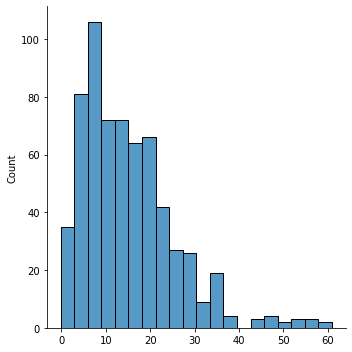

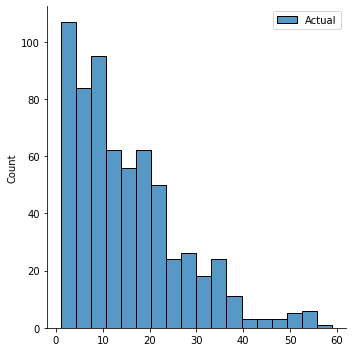

In [40]:
sns.displot(y_predict, label='Predicted')
sns.displot(y_train, label='Actual')

plt.legend()

In [41]:
#Use mean_squared_error to evaluate the model
mean_squared_error(y_train, y_predict, squared=False)

4.803126264657943

In [42]:
#Put all in a function
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df


In [43]:
df_train = read_dataframe('data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('data/green_tripdata_2021-02.parquet')


In [44]:
len(df_train), len(df_val)

(73908, 61921)

In [45]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [46]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [47]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [48]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.75871520559622

In [43]:
#Save lr model
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [44]:
#Using mlfow
with mlflow.start_run():
    mlflow.set_tag('developer', 'Esteban')
    mlflow.log_param('train-data-path', 'data/green_tripdata_2021-01.parquet')
    mlflow.log_param('valid-data-path', 'data/green_tripdata_2021-02.parquet')

    alpha = 0.1
    mlflow.log_param('alpha', alpha)
    ## Lasso model
    lr = Lasso(alpha=alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric('rmse', rmse)

In [49]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope


In [50]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [47]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [48]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[17:08:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:19.27348                          
[1]	validation-rmse:17.58262                          
[2]	validation-rmse:16.09665                          
[3]	validation-rmse:14.79534                          
[4]	validation-rmse:13.65878                          
[5]	validation-rmse:12.66862                          
[6]	validation-rmse:11.80970                          
[7]	validation-rmse:11.06716                          
[8]	validation-rmse:10.42679                          
[9]	validation-rmse:9.87652                           
[10]	validation-rmse:9.40561                          
[11]	validation-rmse:9.00335                          
[12]	validation-rmse:8.66184                          
[13]	validation-rmse:8.37196                          
[14]	validation-rmse:8.12663                         

In [51]:
#Trying with the best model that we got
params = {
'learning_rate':	0.1702604965010781,
'max_depth':        30,
'min_child_weight':	2.698798001436485,
'objective'	:'reg:linear',
'reg_alpha':	0.023323814664873283,
'reg_lambda':	0.054063638463697564,
'seed':	42
}


mlflow.xgboost.autolog()

booset=xgb.train(
    params = params,
    dtrain = train,
    num_boost_round = 1000,
    evals = [(valid, 'validation')],
    early_stopping_rounds = 50

)

2022/05/25 17:45:15 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '88ff214231934119a5527a96106579c7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[17:45:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:18.16692
[1]	validation-rmse:15.70936
[2]	validation-rmse:13.72883
[3]	validation-rmse:12.14186
[4]	validation-rmse:10.88295
[5]	validation-rmse:9.89837
[6]	validation-rmse:9.12680
[7]	validation-rmse:8.53234
[8]	validation-rmse:8.07265
[9]	validation-rmse:7.72165
[10]	validation-rmse:7.45317
[11]	validation-rmse:7.24835
[12]	validation-rmse:7.08878
[13]	validation-rmse:6.96729
[14]	validation-rmse:6.87241
[15]	validation-rmse:6.79865
[16]	validation-rmse:6.74030
[17]	validation-rmse:6.69510
[18]	validation-rmse:6.65688
[19]	validation-rmse:6.62693
[20]	validation-rmse:6.60140
[21]	validation-rmse:6.57999
[22]	validation-rmse:6.56472
[23]	validation-rmse:6.55199
[24]	validation-rmse:6.54053
[25]	validation-rmse:6.53147
[26]	validation-rmse:6.52429
[27]	validation-rmse:6.51772
[28]	validation-

2022/05/25 17:46:15 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\User\anaconda3\envs\mlflow_enviroment\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils."
